<a href="https://colab.research.google.com/github/mscholl96/mad-recime/blob/network_CVAE/network/CVAE/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append(dataPath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/2022_02_11/recipes_valid_0.pkl'
embeddingPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/vocab.bin'

In [3]:
dataPath = 'data/recipes_valid_0.pkl'
embeddingPath = 'data/vocab.bin'

In [4]:
import pickle
import pandas as pd

with open(dataPath, 'rb') as f:
    pklData = pd.DataFrame(pickle.load(f))

print(pklData.keys())
print(len(pklData))

Index(['title', 'ingredients', 'instructions'], dtype='object')
100000


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [3]:
!pip install word2vec

     |████████████████████████████████| 42 kB 795 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=3591c5f1338e1124c0fe16fa803900036c78cf7e01775c3967817f5703020e3b
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [5]:
from src.ReciMePreprocessor import ReciMePreprocessor

preprocessor = ReciMePreprocessor(embeddingPath)
pklData = pklData[:2000]
processedInput = preprocessor.preProcessInput(pklData['ingredients'])

## VAE
### Setup

In [6]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Import custom autoencoder
from src.ReciMeEncoder import ReciMeEncoder
from src.ReciMeEncoder_unstacked import ReciMeEncoder_unstacked

# Import custom helper functions
from src.networkUtils import CustomLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Setup Datasets + Hyperparameters

In [7]:
# One hot encoding without embedding and using sparse frame
train_data, test_data =  train_test_split(processedInput, test_size=0.3, random_state=42)
batch_size = 512
# Definition of batches
trainloader=DataLoader(dataset=torch.FloatTensor(train_data),batch_size=batch_size)
testloader=DataLoader(dataset=torch.FloatTensor(test_data),batch_size=batch_size)

In [8]:
for data in trainloader:
    print(torch.max(data))
    print(torch.min(data))

tensor(1.)
tensor(-1.)
tensor(1.)
tensor(-1.)
tensor(1.)
tensor(-1.)


In [9]:
paramList = [train_data.shape[1], 15000, 10000, 7000, 4000, 2500]

model = ReciMeEncoder(paramList, useBatchNorm=False, actFunc=torch.nn.LeakyReLU(), outFunc=None).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

ReciMeEncoder(
  (encoderStack): Sequential(
    (0): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=6360, out_features=15000, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=15000, out_features=10000, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=10000, out_features=7000, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (3): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=7000, out_features=4000, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (4): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=4000, out_features=2500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (muStack): Linear(in_feat

### Train Model

In [8]:
epochs = 20
log_interval = 5
val_losses = []
train_losses = []
train_losses_MSE = []
train_losses_KLD = []
test_losses = []

In [12]:
def train_otherloss(epoch):
    model.train()
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss = loss_itm
        train_loss_MSE = loss_MSE.item()
        train_loss_KLD = loss_KLD.item()
        train_losses.append(train_loss)
        train_losses_MSE.append(train_loss_MSE)
        train_losses_KLD.append(train_loss_KLD)
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, train_loss, 
            train_loss_MSE , 
            train_loss_KLD))

In [13]:
def test_otherloss(epoch):
    with torch.no_grad():
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss = loss_itm
            test_loss_MSE = loss_MSE
            test_loss_KLD = loss_KLD
            test_losses.append(test_loss)
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, test_loss, 
                test_loss_MSE, 
                test_loss_KLD))

In [9]:
def train(epoch):
    model.train()
    train_loss = 0
    train_loss_MSE = 0
    train_loss_KLD = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss += loss_itm
        train_loss_MSE += loss_MSE.item()
        train_loss_KLD += loss_KLD.item()
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, train_loss / len(trainloader.dataset), 
            train_loss_MSE / len(trainloader.dataset), 
            train_loss_KLD / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))
        train_losses_MSE.append(train_loss_MSE / len(trainloader.dataset))
        train_losses_KLD.append(train_loss_KLD / len(trainloader.dataset))


In [10]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        test_loss_MSE = 0
        test_loss_KLD = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss += loss_itm
            test_loss_MSE += loss_MSE.item()
            test_loss_KLD += loss_KLD.item()
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset), 
                test_loss_MSE / len(testloader.dataset), 
                test_loss_KLD / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [11]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

KeyboardInterrupt: 

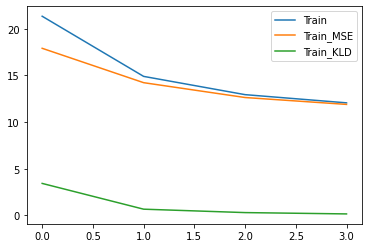

In [36]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_losses_MSE)
plt.plot(train_losses_KLD)
plt.legend(['Train', 'Train_MSE', 'Train_KLD'])
#plt.ylim([0,100])

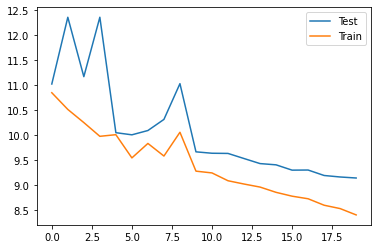

In [13]:
import matplotlib.pyplot as plt
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])

### Draw random samples form latent space and generate new data

In [13]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        break

In [14]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

df = preprocessor.decodeOutput(pred)
df[0]

,amount,unit,ingredient
0,-2816.3584,ounce,handed
1,-3470.0908,quart,coffeecake
2,-1735.2495,,TEA
3,-1168.5161,tablespoon,Raw
4,-1088.3445,package,using
5,-1496.5492,millilitre,oil-free
6,-1533.7627,pint,
7,-1266.0302,,
8,-1336.4442,pint,
9,-399.28998,package,
